In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from matplotlib import font_manager, rc, rcParams
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
rcParams['axes.unicode_minus'] = False

# Data Preprocessing

In [2]:
penguins = pd.read_csv('penguins.csv') # 자료 불러오기
penguins = penguins.dropna(axis=0) # 결측치 제거
penguins.head() # 데이터 확인

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [3]:
def to_numeric(x, names):  # 카테고리 변수를 숫자형 변수로 변환해주는 함수
    numeric_dict = dict([(name, k) for k, name in enumerate(names)])
    
    return numeric_dict[x]

X = penguins.iloc[:, 1:] # 독립변수 선택
y = penguins['species']
y_names = np.unique(y)

# 종속변수 숫자형 변수화...Adelie 0 Chinstrap 1 Gentoo 2
y = y.apply(to_numeric, args=(y_names,))
# 독립변수 중 island 숫자형 변수화...Biscoe 0 Dream 1 Torgersen 2
X.island = X.island.apply(to_numeric, args=(np.unique(X.island),))
# 독립변수 중 sex 숫자형 변수화...암컷 0 수컷 1
X.sex = X.sex.apply(to_numeric, args=(np.unique(X.sex),))

In [30]:
# 독립변수 표준화 (scaling)
def standardize(arr): # 표준화 함수
    return (arr-arr.mean(axis=0))/arr.std(axis=0)

X_std = standardize(X)
X_std.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1.886553,-0.894695,0.779559,-1.424608,-0.567621,0.989542,-1.281813
1,1.886553,-0.821552,0.119404,-1.067867,-0.505525,-1.007534,-1.281813
2,1.886553,-0.675264,0.424091,-0.425733,-1.188572,-1.007534,-1.281813
4,1.886553,-1.333559,1.084246,-0.568429,-0.940192,-1.007534,-1.281813
5,1.886553,-0.858123,1.744400,-0.782474,-0.691811,0.989542,-1.281813


### 결정경계 영역을 그리고 scatter plot을 생성하는 함수

In [6]:
def plot_sphere(X, y, classifier, subplot_size=None, k=None, title_dict=dict()):

    # 분류 성능 시각화 준비작업
    colors = ('red', 'gold', 'dodgerblue')
    markers = ('x', 'o', '^')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot 생성 범위 설정 (x1: x축, x2: y축)
    x1 = X.iloc[:,0].min()-0.5, X.iloc[:,0].max()+0.5
    x2 = X.iloc[:,1].min()-0.5, X.iloc[:,1].max()+0.5
    
    xx1, xx2 = np.meshgrid(np.arange(x1[0], x1[1], 0.02),
                np.arange(x2[0], x2[1], 0.02))
    z = classifier.predict(np.array([xx1.reshape(-1,), xx2.reshape(-1,)]).T)
    if type(classifier) == keras.engine.sequential.Sequential:
        z = z.argmax(axis=1) # 분류기가 Neural Network 종류인 경우 predict값 변환
    z = z.reshape(xx1.shape)
    
    # 모델 parameter에 따른 영역 구분 subplot 생성
    if subplot_size: # subplot이 존재하는 경우 subplot 생성
        fig.add_subplot(subplot_size[0], subplot_size[1], k)

    # 영역을 나누고 색을 채우는 함수 cf)contour는 영역 나누기만 함
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    title = '' # title 작성
    for key, value in title_dict.items():
        title += f'{key}: {value} '
    y_pred = classifier.predict(X) # 분류기에 따른 예측값
    # 분류기가 Neural Network 종류인 경우 predict값 변환
    if type(classifier) == keras.engine.sequential.Sequential:
        y_pred = y_pred.argmax(axis=1) 
    plt.title(f'{title}정확도: {accuracy_score(y, y_pred):.4f}',
              fontsize=14)
    plt.xlabel(f'{X.columns[0]}', fontsize=10)
    plt.ylabel(f'{X.columns[1]}', fontsize=10)

    # 실제 자료 scatter plot 생성
    for i in range(len(X)):
        plt.scatter(X.iloc[i,0], X.iloc[i,1], 
                    c=colors[y.iloc[i]], marker=markers[y.iloc[i]], s=15)

# Logistic Regression

### logistic regression with no-penalty

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='none', solver='lbfgs', 
                        multi_class='auto', max_iter=1000)
lr.fit(X_std, y)
y_pred = lr.predict(X_std)

print(f'정확도: {accuracy_score(y, y_pred):.4f}')

정확도: 1.0000


### logistic regression with penalty (Elasticnet, Lasso, Ridge)

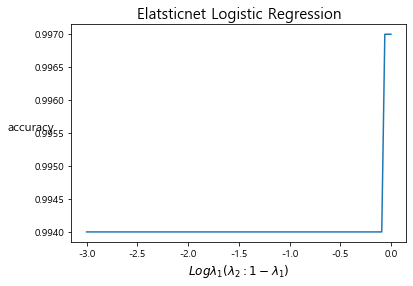

In [8]:
accuracy = []
for l1 in np.linspace(-3,0,100):
    lr_Elastic = LogisticRegression(penalty='elasticnet', l1_ratio=10.0**l1, solver='saga',
                                    multi_class='auto', max_iter=1000)
    lr_Elastic.fit(X_std, y)
    y_pred = lr_Elastic.predict(X_std)

    accuracy.append(accuracy_score(y, y_pred)) # accuracy 리스트에 정확도 추가
    
plt.plot(np.linspace(-3,0,100), accuracy)
plt.title('Elatsticnet Logistic Regression', fontsize=15)
plt.xlabel(r'$Log\lambda_1 (\lambda_2: 1-\lambda_1)$', fontsize=12)
plt.ylabel('accuracy', fontsize=12, rotation=0)
plt.show()

### non-penalty 와 elasticnet-penalty 비교 (독립변수 bill_depth, flipper_length)

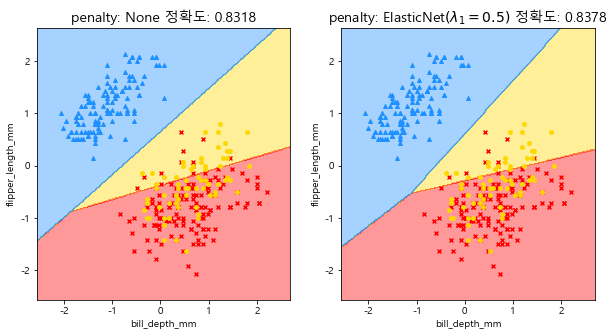

In [9]:
X_temp = X_std.iloc[:, [2,3]]

lr = LogisticRegression(penalty='none', solver='lbfgs', 
                        multi_class='auto', max_iter=1000)
lr.fit(X_temp, y)

lr_Elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga',
                                multi_class='auto', max_iter=1000)
lr_Elastic.fit(X_temp, y)

fig = plt.figure(figsize=(10,5))
plot_sphere(X_temp, y, lr, 
            subplot_size=(1,2), k=1, title_dict={'penalty': 'None'})
plot_sphere(X_temp, y, lr_Elastic, 
            subplot_size=(1,2), k=2, title_dict={r'penalty': 'ElasticNet$(\lambda_1=0.5)$'})

###### elasticnet penalty를 적용했을 때 조금 나은 정확도를 보이는 듯했지만 눈에 띄는 수준으로 정확도가 향상되지는 않았다.

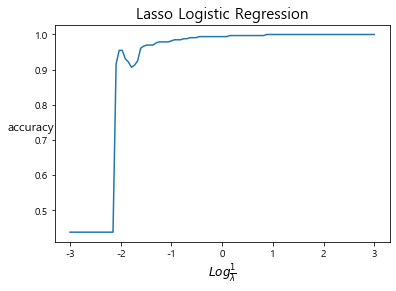

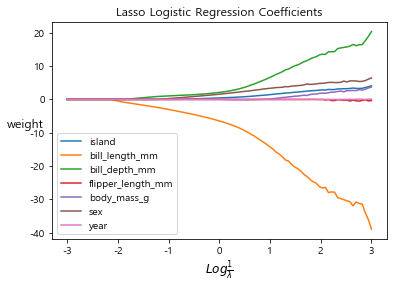

In [10]:
accuracy = []
coefs = []

for c in np.linspace(-3,3,100):
    lr_Lasso = LogisticRegression(penalty='l1', C=10.0**c, solver='liblinear',
                                  multi_class='auto', max_iter=1000)
    lr_Lasso.fit(X_std, y)
    y_pred = lr_Lasso.predict(X_std)
    coefs.append(lr_Lasso.coef_[0])
    
    accuracy.append(accuracy_score(y, y_pred))
    
coefs_df = pd.DataFrame(coefs, columns=X_std.columns)
coefs_df.index = np.linspace(-3,3,100)

plt.plot(np.linspace(-3,3,100), accuracy)
plt.title('Lasso Logistic Regression', fontsize=15)
plt.xlabel(r'$Log \frac{1}{\lambda}$', fontsize=12)
plt.ylabel('accuracy', fontsize=12, rotation=0)
plt.show()

coefs_df.plot()
plt.title('Lasso Logistic Regression Coefficients')
plt.xlabel(r'$Log \frac{1}{\lambda}$', fontsize=12)
plt.ylabel('weight', fontsize=12, rotation=0)
plt.show()

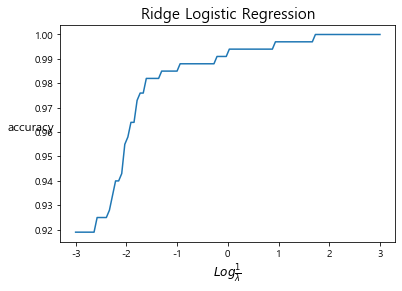

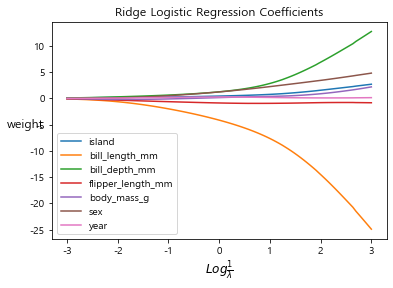

In [11]:
accuracy = []
coefs = []

for c in np.linspace(-3,3,100):
    lr_Ridge = LogisticRegression(penalty='l2', C=10.0**c, solver='liblinear',
                                  multi_class='auto', max_iter=1000)
    lr_Ridge.fit(X_std, y)
    y_pred = lr_Ridge.predict(X_std)
    coefs.append(lr_Ridge.coef_[0])
    
    accuracy.append(accuracy_score(y, y_pred))
    
coefs_df = pd.DataFrame(coefs, columns=X_std.columns)
coefs_df.index = np.linspace(-3,3,100)

plt.plot(np.linspace(-3,3,100), accuracy)
plt.title('Ridge Logistic Regression', fontsize=15)
plt.xlabel(r'$Log \frac{1}{\lambda}$', fontsize=12)
plt.ylabel('accuracy', fontsize=12, rotation=0)
plt.show()

coefs_df.plot()
plt.title('Ridge Logistic Regression Coefficients')
plt.xlabel(r'$Log \frac{1}{\lambda}$', fontsize=12)
plt.ylabel('weight', fontsize=12, rotation=0)
plt.show()

# LDA / QDA

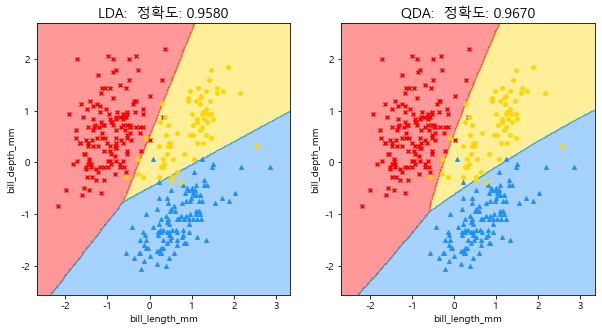

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

X_temp = X_std.iloc[:, [1,2]]

fig = plt.figure(figsize=(10,5))

# LDA 모델 생성
lda = LDA(n_components=2)
lda.fit(X_temp, y)

# QDA 모델 생성
qda = QDA()
qda.fit(X_temp, y)

# LDA와 QDA 분류 성능 비교
plot_sphere(X_temp, y, lda, subplot_size=(1,2), k=1, 
            title_dict={'LDA': ''})
plot_sphere(X_temp, y, qda, subplot_size=(1,2), k=2, 
            title_dict={'QDA': ''})

# SVM

### 선형 SVM (독립변수 모두 포함)

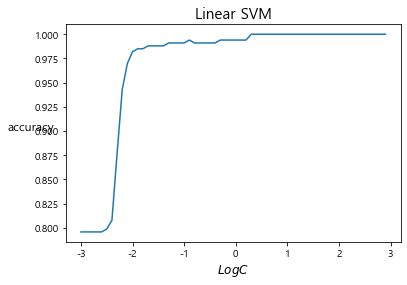

In [13]:
from sklearn.svm import SVC

accuracy = []
for C in np.arange(-3, 3, 0.1):
    svm = SVC(kernel='linear', C=10**C, random_state=1)
    svm.fit(X_std, y)

    y_pred = svm.predict(X_std)
    accuracy.append(accuracy_score(y, y_pred))
    
plt.plot(np.arange(-3, 3, 0.1), accuracy)
plt.title('Linear SVM', fontsize=15)
plt.xlabel(r'$LogC$', fontsize=12)
plt.ylabel('accuracy', fontsize=12, rotation=0)
plt.show()

###### C값이 작으면 모델의 정확도가 낮다.

### 선형 SVM (독립변수 임의로 선택-bill_length / bill_depth)

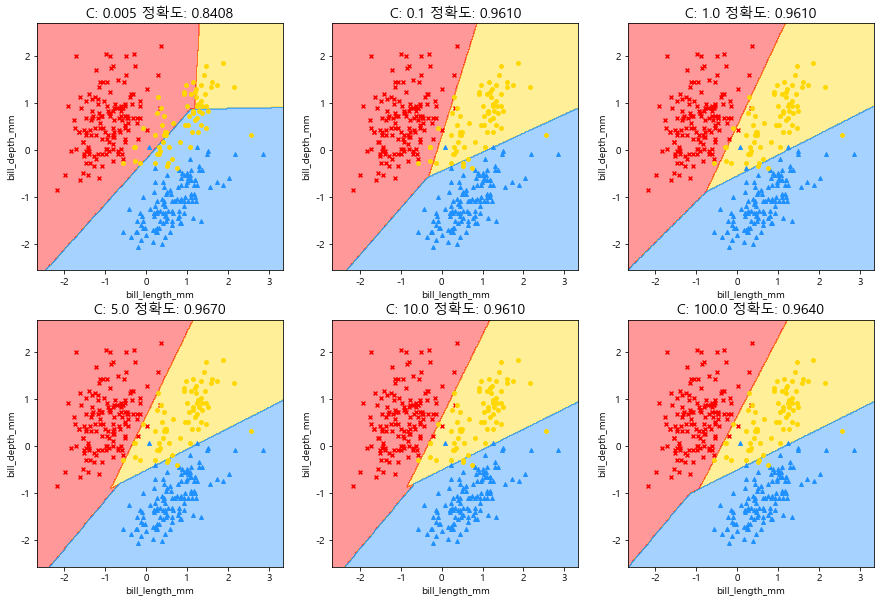

In [14]:
X_temp = X_std.iloc[:, 1:3]

fig = plt.figure(figsize=(15, 10))
k = 1

for C in [0.005, 0.1, 1.0, 5.0, 10.0, 100.0]:
    svm = SVC(kernel='linear', C=C, random_state=1)
    svm.fit(X_temp, y)
    plot_sphere(X_temp, y, svm, subplot_size=(2,3), k=k,
               title_dict={'C': C})
    k += 1

###### C가 클수록 오분류를 받아들이는 정도가 작아지는 경향을 보인다.
###### 즉 C가 작으면 오분류를 최대한 감수하겠다는 의미이다. (다시말해 에러가 커질 수 있다.)
###### C가 0.005, 100일 때를 비교해보면 그 차이가 확실히 드러난다.
###### 이 예시에서는 C를 0.1로 선택하는 것이 바람직해 보인다.

### 비선형 SVM 1 (독립변수 임의로 선택-bill_length / bill_depth)

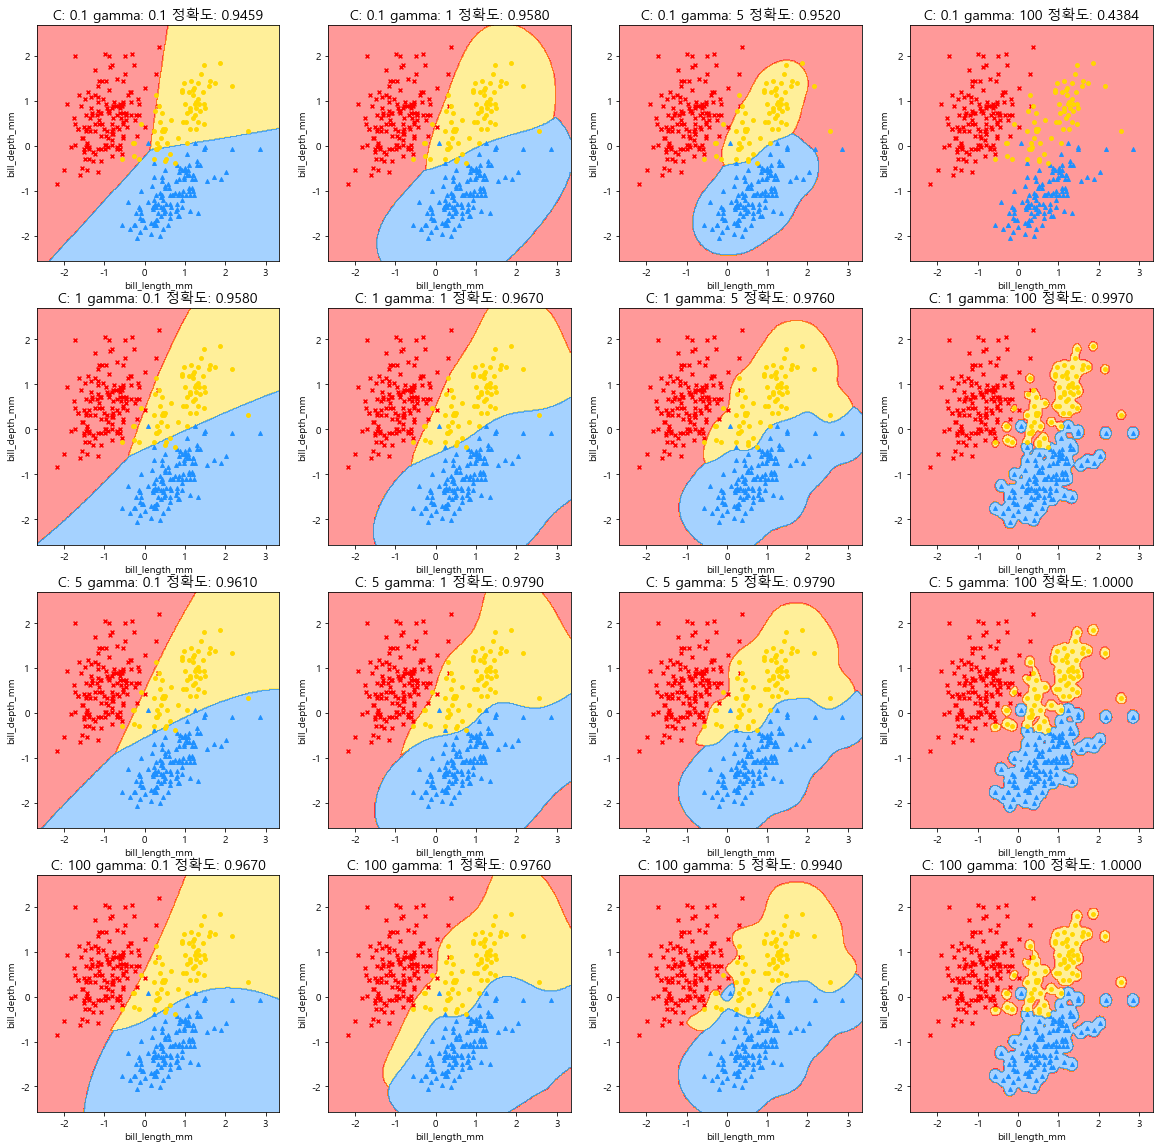

In [15]:
X_temp = X_std.iloc[:,1:3]

k = 1 # subplot 순서를 위한 변수
fig = plt.figure(figsize=(20,20))

for C in [0.1, 1, 5, 100]: # C값 변화
    for gamma in [0.1, 1, 5, 100]: # gamma값 변화
        # kernel함수로 가우시안 RBF 이용
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=1)
        svm.fit(X_temp, y)
        plot_sphere(X_temp, y, svm, subplot_size=(4,4), k=k,
                   title_dict={'C': C, 'gamma': gamma})
        k += 1

###### gamma값이 일정할 때 (0.1) C의 값이 커질수록 error(오분류)를 줄이려는 경향을 보인다.
###### C값이 일정할 때 (1) gamma값이 커질수록 결정경계가 더 울퉁불퉁해진다.
###### 이 예시에서 최적의 C와 gamma는 (5, 0.1) 또는 (1, 0.1) 정도로 선택해볼 수 있겠다.

### 비선형 SVM 2 (독립변수 임의로 선택-bill_length / flipper_length)

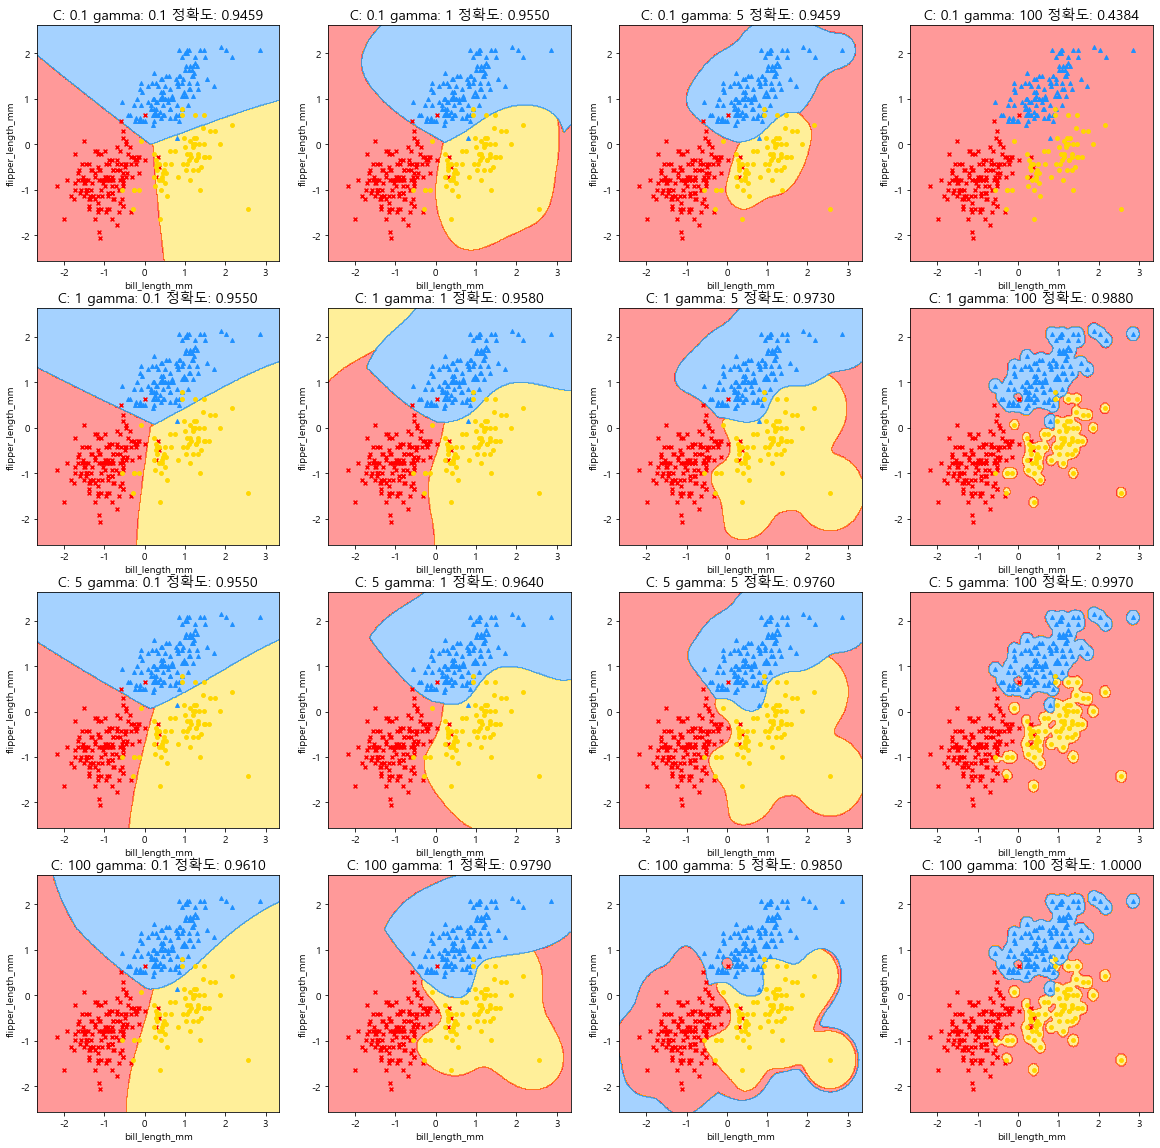

In [16]:
X_temp = X_std.iloc[:,[1,3]]

fig = plt.figure(figsize=(20,20))
k = 1

for C in [0.1, 1, 5, 100]:
    for gamma in [0.1, 1, 5, 100]:
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=1)
        svm.fit(X_temp, y)
        plot_sphere(X_temp, y, svm, subplot_size=(4,4), k=k,
                   title_dict={'C': C, 'gamma': gamma})
        k += 1

### 비선형 SVM 3 (독립변수 임의로 선택-flipper_length / body_mass)

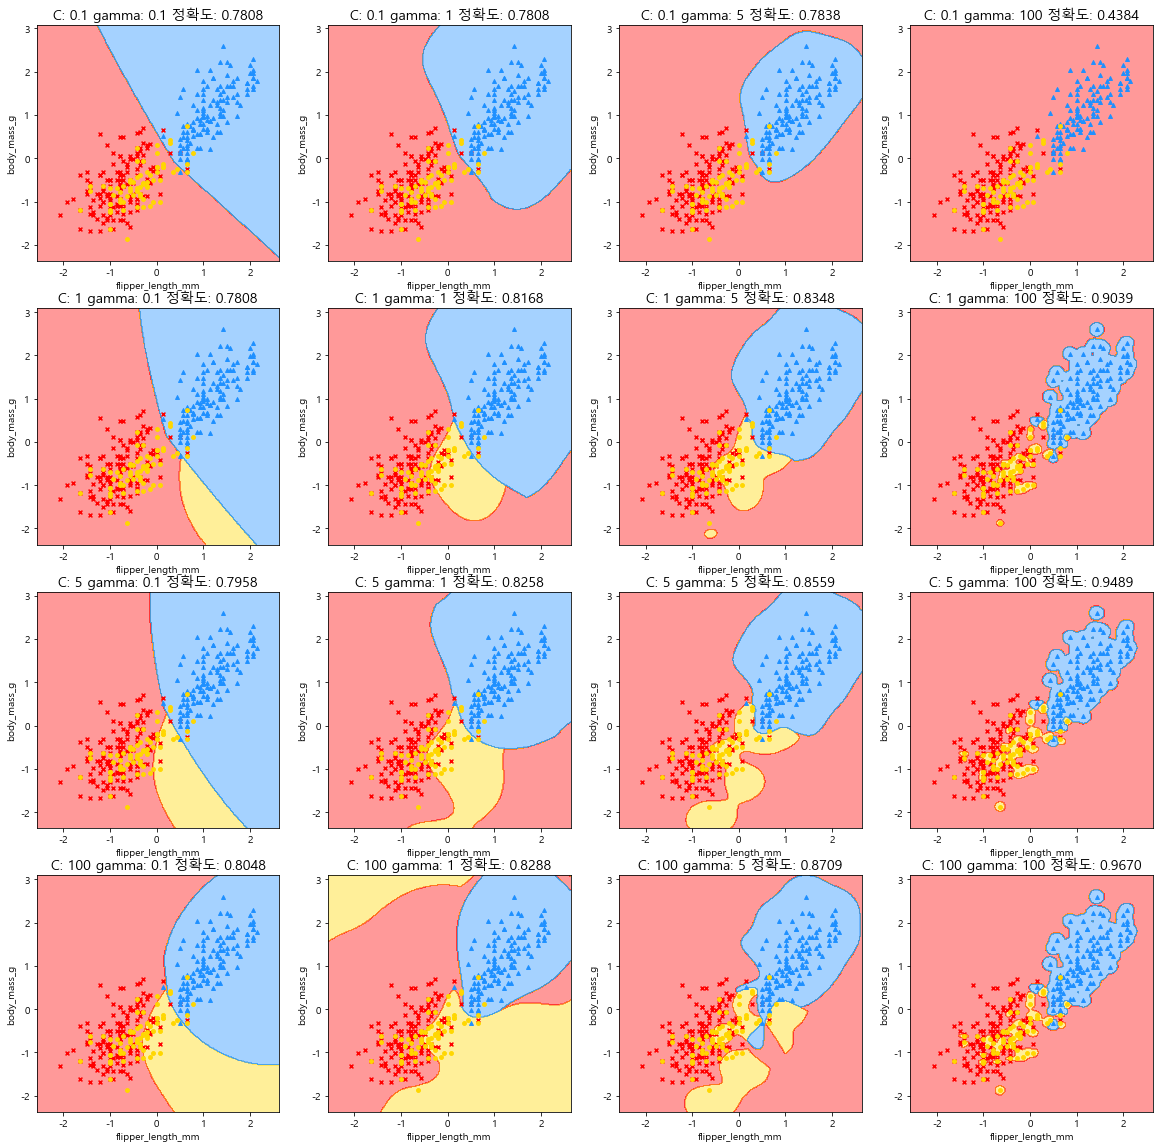

In [17]:
X_temp = X_std.iloc[:,[3,4]]

fig = plt.figure(figsize=(20,20))
k = 1

for C in [0.1, 1, 5, 100]:
    for gamma in [0.1, 1, 5, 100]:
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=1)
        svm.fit(X_temp, y)
        plot_sphere(X_temp, y, svm, subplot_size=(4,4), k=k,
                   title_dict={'C': C, 'gamma': gamma})
        k += 1

# Tree / Random Forest / Boosting

### Tree

### tree에 모든 독립변수를 넣었을 때

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=5, random_state=1)
tree.fit(X_std, y)
y_pred = tree.predict(X_std)
accuracy_score(y, y_pred) # 정확도 계산

0.996996996996997

### 독립변수 2개 선택하여 tree에 넣고 max_depth 변화에 따라 분류 시각화(bill_length, bill_depth)

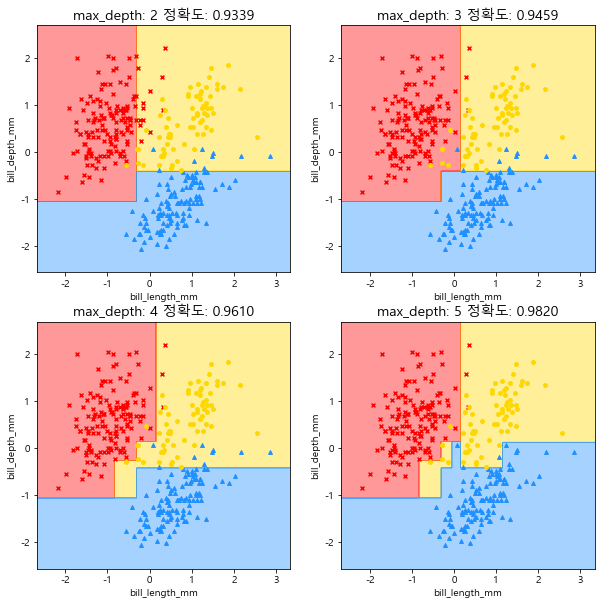

In [19]:
X_temp = X_std.iloc[:,[1,2]]

fig=plt.figure(figsize=(10,10))
k = 1

for d in range(2,6):
    tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=d, random_state=1)
    tree.fit(X_temp, y)
    plot_sphere(X_temp, y, tree, 
                subplot_size=(2,2), k=k,
               title_dict={'max_depth': d})
    k += 1

###### 결정경계를 보았을 때 max_depth 4 또는 5일때 overfitting 가능성이 높아 보인다.
###### 분류 영역과 분류 성능을 고려했을 때 max_depth 3이 적절하다고 판단된다.

### 독립변수 2개 선택하여 tree에 넣고 max_depth 변화에 따라 분류 시각화(bill_length, flipper_length)

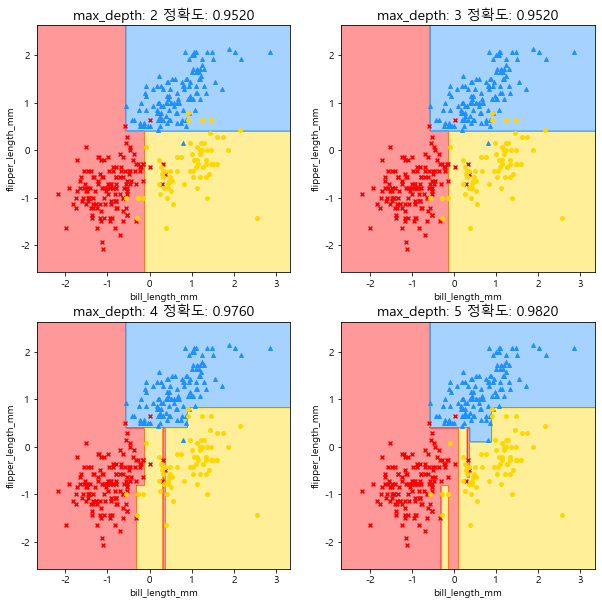

In [20]:
X_temp = X_std.iloc[:,[1,3]]

fig=plt.figure(figsize=(10,10))
k = 1

for d in range(2,6):
    tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=d, random_state=1)
    tree.fit(X_temp, y)
    plot_sphere(X_temp, y, tree, 
                subplot_size=(2,2), k=k,
               title_dict={'max_depth': d})
    k += 1

###### max_depth 4 5에서 overfitting 가능성이 매우 높은 것으로 보인다.
###### 위 예시와 마찬가지로 max_depth 3을 선택하는 것이 적절하다고 판단된다.

In [21]:
# tree를 그려보려고 하였으나 마지막에 에러가 발생하였음

# from pydotplus.graphviz import graph_from_dot_data
# from sklearn.tree import export_graphviz
# from IPython.display import Image

# dot_data = export_graphviz(tree,
#                            filled=True, 
#                            rounded=True,
#                            class_names=y_names,
#                            feature_names=X.columns,
#                            out_file=None) 
# graph = graph_from_dot_data(dot_data)
# graph.write_png('tree.png')

### RandomForest 독립변수 bill_depth, flipper_length

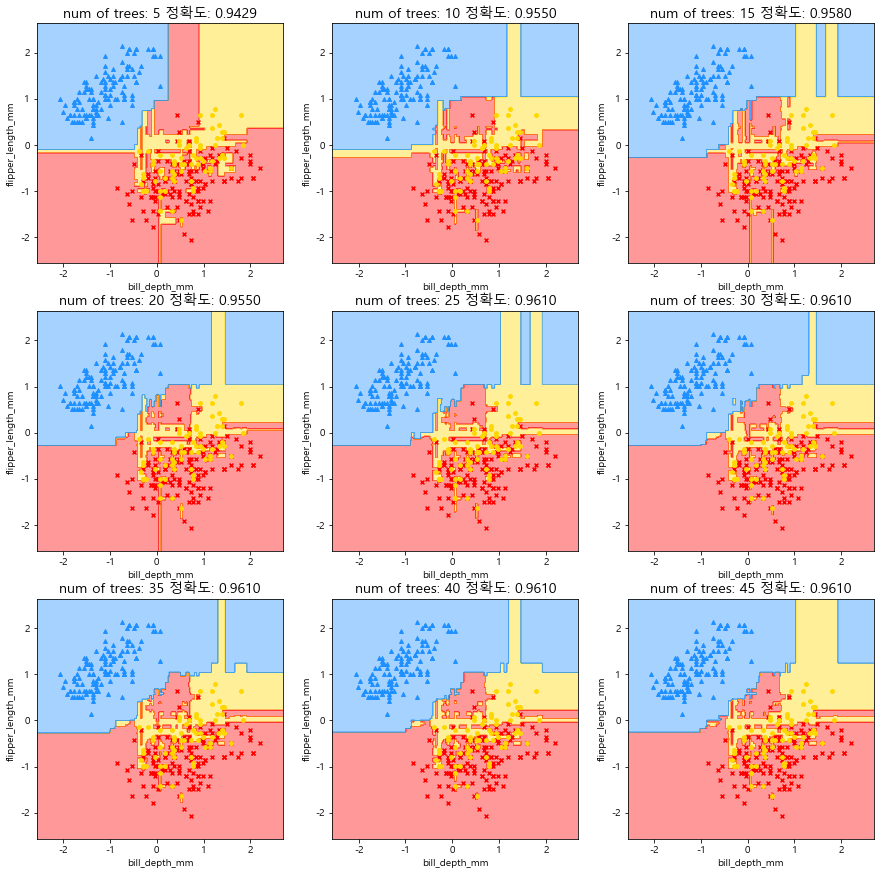

In [22]:
from sklearn.ensemble import RandomForestClassifier

X_temp = X_std.iloc[:, [2,3]]

fig = plt.figure(figsize=(15,15))
k = 1

# 랜덤포레스트에서 이용하는 트리의 수
for ntree in np.arange(5, 46, 5):
    forest = RandomForestClassifier(criterion='gini', n_estimators=ntree,
                                   random_state=1, n_jobs=2)
    forest.fit(X_temp, y)
    plot_sphere(X_temp, y, forest, 
                subplot_size=(3,3), k=k,
                title_dict={'num of trees': ntree})
    k += 1

###### 앙상블에 사용된 트리의 개수가 증가할수록 정확도가 향상되는 추세를 보이다가 일정 수준에서 더이상 증가하지 않았다.

### Bagging with RandomForest (독립변수 bill_length, bill_depth)

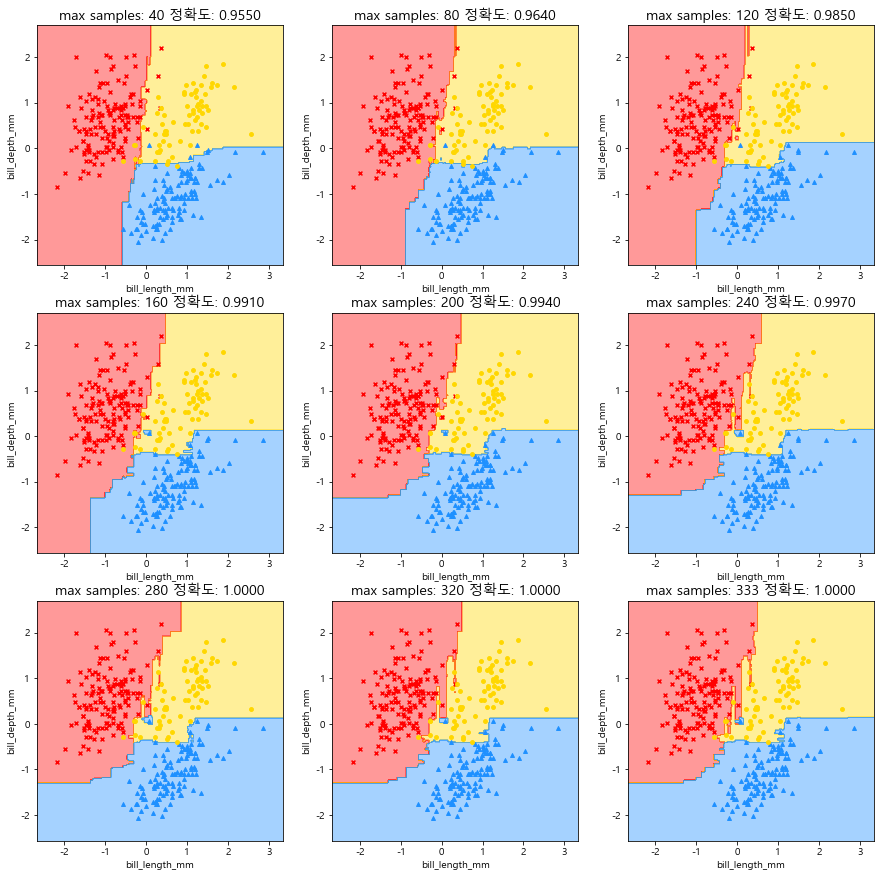

In [23]:
X_temp = X_std.iloc[:, [1,2]]

fig = plt.figure(figsize=(15,15))
k = 1

DecisionTreeClassifier()

# bootstrap으로 사용하는 샘플 수
for sam in np.concatenate([np.arange(40, 321, 40), [len(X_temp)]]):
    forest = RandomForestClassifier(criterion='gini', n_estimators=30,
                                   random_state=1, n_jobs=2,
                                   max_samples=sam)
    forest.fit(X_temp, y)
    plot_sphere(X_temp, y, forest, 
                subplot_size=(3,3), k=k,
                title_dict={'max samples': sam})
    k += 1

###### Bagging의 효과는 이상치(outlier)에 의한 모델 왜곡을 막아주는 것인데
###### 여기서 이용한 데이터에서는 두드러지게 나타난 outlier를 확인하지는 못했다.
###### 즉, 이 데이터 셋에서는 굳이 bagging을 이용하기보다는 최대로 담을 수 있는 샘플을 담는 것이 나아 보인다.

### AdaBoosting과 GradientBoosting(독립변수 bill_length, bill_depth)

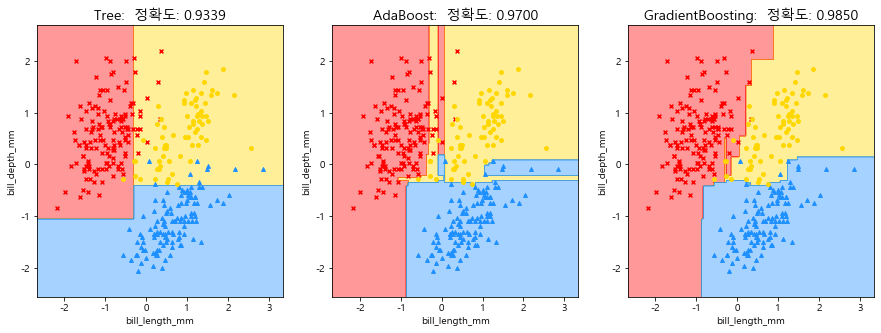

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_temp = X_std.iloc[:, [1,2]]

# tree의 depth는 2로 설정 (약한 분류)
tree = DecisionTreeClassifier(criterion='gini', 
                              random_state=1, max_depth=2)
# 위에서 설정한 tree를 약한 분류기로 AdaBoost에 주입
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500,
                        learning_rate=0.1, random_state=1)
# GradientBoosting 모델, 사용 트리 개수 20개
grad = GradientBoostingClassifier(n_estimators=20, 
                                  random_state=1)

tree.fit(X_temp, y)
ada.fit(X_temp, y)
grad.fit(X_temp, y)

fig = plt.figure(figsize=(15,5))

plot_sphere(X_temp, y, tree, subplot_size=(1,3), k=1, title_dict={'Tree': ''})
plot_sphere(X_temp, y, ada, subplot_size=(1,3), k=2, title_dict={'AdaBoost': ''})
plot_sphere(X_temp, y, grad, subplot_size=(1,3), k=3, title_dict={'GradientBoosting': ''})

###### AdaBoost 적용 결과 정확도가 높아졌고, GradientBoosting 적용 결과 정확도가 더 높아졌다.

# NN / DNN

In [25]:
from keras.utils.np_utils import to_categorical

# neural network에 주입할 종속변수 one-hot-encoding
y_n = to_categorical(y)

### two-layers Neural Network (모든 독립변수 포함)

Epoch 1/20
7/7 [==============================] - 0s 2ms/step - loss: 1.3904 - accuracy: 0.1261
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.2032 - accuracy: 0.2042
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 1.0770 - accuracy: 0.3604
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9713 - accuracy: 0.5405
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8791 - accuracy: 0.6787
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7966 - accuracy: 0.7598
Epoch 7/20
7/7 [==============================] - 0s 1ms/step - loss: 0.7246 - accuracy: 0.8258
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.8649
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.8889
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.9069
Epoch 11/20
7/7 [======================

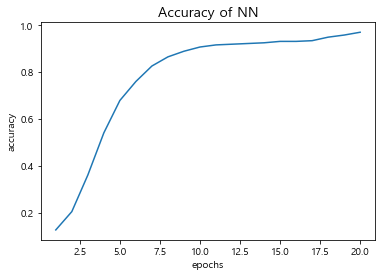

In [26]:
from keras.models import Sequential
from keras.layers import Dense

# 2-layers NN 모델 생성
nn = Sequential()
nn.add(Dense(32, activation='relu', input_shape=(7,)))
nn.add(Dense(3, activation='softmax'))
nn.compile(optimizer='rmsprop', metrics=['accuracy'], 
           loss='categorical_crossentropy')
history = nn.fit(X_std, y_n, epochs=20, batch_size=50)

# epoch 진행에 따른 accuracy 시각화
accuracy = history.history['accuracy']
plt.plot(np.arange(1,21), accuracy)
plt.title('Accuracy of NN', fontsize=14)
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

### four-layers Deep Neural Network

Epoch 1/20
7/7 [==============================] - 0s 1ms/step - loss: 0.9030 - accuracy: 0.7387
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7448 - accuracy: 0.8829
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6151 - accuracy: 0.9189
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.9399
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.3858 - accuracy: 0.9459
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.9610
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.9790
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9790
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9850
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9880
Epoch 11/20
7/7 [======================

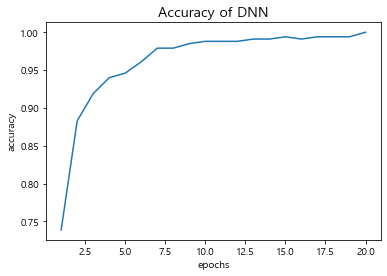

In [27]:
# 4-layers DNN 모델 생성
dnn = Sequential()
dnn.add(Dense(32, activation='relu', input_shape=(7,)))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(3, activation='softmax'))

dnn.compile(optimizer='rmsprop', metrics=['accuracy'], 
            loss='categorical_crossentropy')
history = dnn.fit(X_std, y_n, epochs=20, batch_size=50)

# epoch 진행에 따른 accuracy 시각화
accuracy = history.history['accuracy']
plt.plot(np.arange(1,21), accuracy)
plt.title('Accuracy of DNN', fontsize=14)
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

### NN - DNN 비교를 위해 독립변수 2개(bill_length, bill_depth) 설정 후 영역 plot

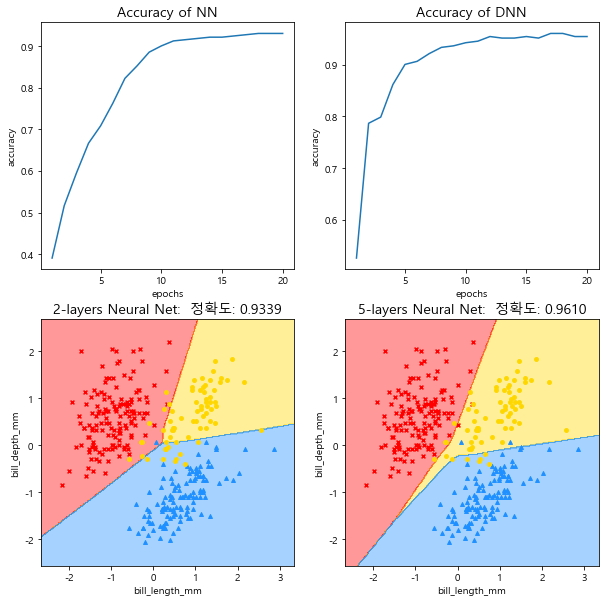

In [31]:
X_temp = X_std.iloc[:, [1,2]]

fig = plt.figure(figsize=(10,10))

nn = Sequential()
nn.add(Dense(32, activation='relu', input_shape=(2,)))
nn.add(Dense(3, activation='softmax'))
nn.compile(optimizer='rmsprop', metrics=['accuracy'], 
           loss='categorical_crossentropy')
history_nn = nn.fit(X_temp, y_n, epochs=20, 
                    batch_size=50, verbose=0)

dnn = Sequential()
dnn.add(Dense(32, activation='relu', input_shape=(2,)))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(3, activation='softmax'))
dnn.compile(optimizer='rmsprop', metrics=['accuracy'], 
            loss='categorical_crossentropy')
history_dnn = dnn.fit(X_temp, y_n, epochs=20, 
                      batch_size=50, verbose=0)

accuracy_nn = history_nn.history['accuracy']
fig.add_subplot(2,2,1)
plt.plot(np.arange(1,21), accuracy_nn)
plt.title('Accuracy of NN', fontsize=14)
plt.xlabel('epochs')
plt.ylabel('accuracy')

accuracy_dnn = history_dnn.history['accuracy']
fig.add_subplot(2,2,2)
plt.plot(np.arange(1,21), accuracy_dnn)
plt.title('Accuracy of DNN', fontsize=14)
plt.xlabel('epochs')
plt.ylabel('accuracy')

plot_sphere(X_temp, y, nn, subplot_size=(2,2), k=3, 
            title_dict={'2-layers Neural Net': ''})
plot_sphere(X_temp, y, dnn, subplot_size=(2,2), k=4, 
            title_dict={'5-layers Neural Net': ''})

###### 최초 epoch부터 DNN의 정확도가 높은 지점에서 출발해서 마지막에도 더 높은 정확도를 보인다.
###### DNN의 경우 결정경계를 비교적으로 더 세밀하게 결정하여 정확도를 높이는 경향을 보인다.